to hsv 2.643136739730835
back 0.020330429077148438


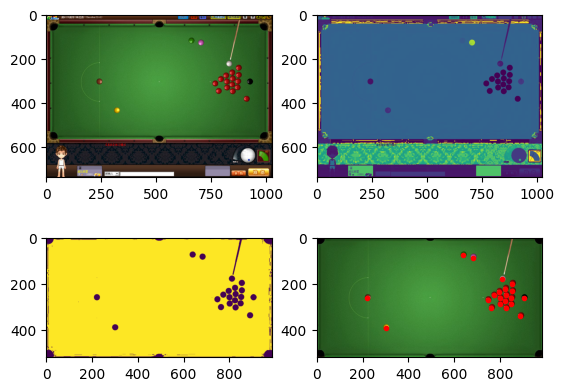

ball 0.43966221809387207
detect 0.0020911693572998047
[3 6 0 1 1 1 1 1 1 1 4 1 7 1 1 1 1 1 1 1 2]


In [155]:
from PIL import Image
from skimage.io import imread
from skimage import color
from time import time
import numpy as np
from numpy.linalg import norm
import scipy.ndimage as ndimg
import matplotlib.pyplot as plt

# RGB转换HSV空间
def rgb2hsv(rgb):
    hsv = np.zeros(rgb.shape, dtype=np.float32)
    cmax = rgb.max(axis=-1)
    #crng = rgb.ptp(axis=-1) # old
    crng = np.ptp(rgb, axis = -1)
    np.clip(cmax, 1, 255, out=hsv[:,:,1])
    np.divide(crng, hsv[:,:,1], out=hsv[:,:,1])
    np.divide(cmax, 255, out=hsv[:,:,2])
    maxidx = np.argmax(rgb, axis=-1).ravel()
    colrgb = rgb.reshape(-1,3)
    idx = np.arange(colrgb.shape[0])
    lut = np.array([[1,2,0],[2,0,1]], dtype=np.uint8)
    h = (colrgb[idx, lut[0][maxidx]]).astype(np.float32)
    h -= colrgb[idx, lut[1][maxidx]]
    h[h==0] = 1
    np.clip(crng, 1, 255, out=crng)
    h /= crng.ravel()
    h += np.array([0,2,4], dtype=np.uint8)[maxidx]
    h /= 6; h %= 1
    hsv[:,:,0] = h.reshape(hsv.shape[:2])
    return hsv

# 制作HSV索引表
def make_lut():
    arr = np.mgrid[0:256,0:256,0:256].reshape(3,-1).T
    arr = arr.astype(np.uint8)
    lut = rgb2hsv(arr.reshape(1,-1,3))
    lut = (lut[0,:,0]*255).astype(np.uint8)
    return lut.reshape(256,256,256)

# 利用索引进行RGB到HSV转换
def rgb2hsv_lut(rgb, lut=[None]):
    if lut[0] is None: lut[0] = make_lut()
    r,g,b = rgb.reshape(-1,3).T
    return lut[0][r,g,b].reshape(rgb.shape[:2])
    
# 计算角度
def angleX(v):
    a = np.arccos(v[:,0] / (norm(v[:,:2], axis=1)+1e-5))
    return np.where(v[:,1]>=0,a ,np.pi * 2 - a)

# 精确定位, 根据圆心和采样点，组建法方程，进行最小二乘估计
def exactly(O, r, pts):
    n = len(pts)
    B = np.zeros((n*2, n+3))
    L = np.zeros(n*2)
    appro = np.zeros(n+3)
    appro[:n] = angleX(pts-O)
    appro[n:] = [O[0], O[1], r]
    try:
        for i in range(2): # 两次迭代，确保达到稳定
            L[::2] = appro[n]+appro[-1]*np.cos(appro[:n])-pts[:,0]
            L[1::2] = appro[n+1]+appro[-1]*np.sin(appro[:n])-pts[:,1]
            B[range(0,n*2,2),range(n)] = -appro[-1]*np.sin(appro[:n])
            B[range(1,n*2,2),range(n)] = appro[-1]*np.cos(appro[:n])
            B[::2,n],B[1::2,n+1] = 1, 1
            B[::2,-1] = np.cos(appro[:n])
            B[1::2,-1] = np.sin(appro[:n])
            NN = np.linalg.inv(np.dot(B.T,B))
            x = np.dot(NN, np.dot(B.T,L))
            v = np.dot(B,x)-L
            appro -= x
    except:
        print(O, r, pts)
    if not(appro[-1]>5 and appro[-1]<50): 
        return (None, None), None
    return appro[[-3,-2]], appro[-1]

#a = np.arccos(v[:,0] / norm(v[:,:2], axis=1))
# 查找背景
def find_ground(img, tor=5):
    r, c = np.array(img.shape[:2])//2
    center = img[r-100:r+100, c-100:c+100]
    back = np.argmax(np.bincount(center.ravel()))
    msk = np.abs(img.astype(np.int16) - back)<tor
    lab, n = ndimg.label(msk)
    hist = np.bincount(lab.ravel())
    if hist[1:].max() < 1e4: return None
    if np.argmax(hist[1:])==0: return None
    msk = lab == np.argmax(hist[1:]) + 1
    sr, sc = ndimg.find_objects(msk)[0]
    loc = sr.start, sc.start
    size = sr.stop - loc[0], sc.stop - loc[1]
    return loc, size, sr, sc, msk[sr, sc]

# 查找一个球
def find_one(img, cs, r=18, a=20):
    h, w = img.shape
    if cs[0]<r+1 or cs[1]<r+1 or cs[0]>h-r-1 or cs[1]>w-r-1:
        return (None, None), None
    rs, pts = np.arange(r), []
    for i in np.linspace(0, np.pi*2, a, endpoint=False):
        rcs = rs[:,None] * (np.cos(i), np.sin(i)) + cs
        rcs = rcs.round().astype(int).T
        ns = rs[img[rcs[0], rcs[1]]]
        if len(ns)==0: continue
        pts.append(rcs.T[ns.min()])
    if len(pts)<10: return (None, None), None
    return exactly(cs, r, np.array(pts))

# 检测球
def find_ball(img):
    dist = ndimg.binary_dilation(img, np.ones((13, 13)))
    dist[:,[0,-1]] = 0; dist[[0,-1],:] = 0
    lab, n = ndimg.label(~dist)
    objs = ndimg.find_objects(lab)[1:]
    cs = [(i.start+i.stop, j.start+j.stop) for i,j in objs]
    balls = []
    for i in np.array(cs)/2:
        (r, c), ra = find_one(img, i)
        if not ra is None: balls.append([r, c, ra])
    if len(balls)==0: return balls
    balls = np.array(balls)
    balls[:,2] = balls[:,2].mean()-0.5
    return balls

# 提取颜色
def detect_color(img, balls, mode='snooker'):
    r = int(balls[0,2]) - 1
    rcs = np.mgrid[-r:r+1, -r:r+1].reshape(2,-1).T
    rcs = rcs[norm(rcs, axis=1) < r]
    colors = []
    for r,c in balls[:,:2]:
        rs, cs = (rcs + (int(r), int(c))).T
        colors.append(img[rs, cs])
    colors = np.array(colors).astype(np.int16)
    colors = np.sort(colors, axis=1)
    colors = colors[:,len(rcs)//4:-len(rcs)//4]
    if mode=='snooker':
        snklut = [21, 0, 34, 73, 12, 171, 221, 42]
        cs = [np.argmax(np.bincount(i)) for i in colors]
        diff = np.abs(np.array(cs)[:,None] - snklut)
        return np.argmin(diff, axis=-1)
    
    if mode=='black8':
        bins = np.array([np.bincount(i, minlength=256) for i in colors])
        mean = np.argmax(bins, axis=-1)
        std = (np.std(colors, axis=1)>1) + 1
        std[(std==1) & (np.abs(mean-42)<3)] = 7
        n = (np.abs(colors-28)<3).sum(axis=1)
        n = bins[:,25:30].max(axis=1)
        #print(mean)
        #print(np.bincount(colors[5]))
        #print(np.bincount(colors[9]))
        std[np.argmax(n)] = 0
        return std

# lut = np.load('lut.npy')
# 提取球桌信息
def extract_table(img, mode='snooker'):
    """
    提取球桌信息：先做色彩空间转换，调用find_ground找背景，调用find_ball找球，再用detect_color识别球的种类。
    """
    #hsv = (rgb2hsv(img[:,:,:3]) * 255).astype(np.uint8)
    hsv = rgb2hsv_lut(img)
    ground = find_ground(hsv)
    if ground is None: return '未检测到球桌，请勿遮挡'
    loc, size, sr, sc, back = ground
    balls = find_ball(back)
    if len(balls)==0: return '全部球已入袋'
    tps = detect_color(hsv[sr, sc], balls, mode)
    balls = np.hstack((balls, tps[:,None]))
    return loc, size, img[sr, sc], balls
    
if __name__ == '__main__':
    img = imread('window_capture_20250614_194521.png')[:,:,:3]
    start = time()
    #hsv = (rgb2hsv(img[:,:,:0]) * 255).astype(np.uint8)
    ax = plt.subplot(221)
    ax.imshow(img)

    hsv = rgb2hsv_lut(img)
    print('to hsv', time()-start)
    ax = plt.subplot(222)
    ax.imshow(hsv)

    start = time()
    loc, size, sr, sc, back = find_ground(hsv)
    print('back', time()-start)
    ax = plt.subplot(223)
    ax.imshow(back)

    start = time()
    balls = find_ball(back)

    ax = plt.subplot(224)
    ax.imshow(img[sr, sc])
    ax.plot(balls[:,1], balls[:,0], 'r.')

    plt.show()

    print('ball', time()-start)

    start = time()
    tps = detect_color(hsv[sr, sc], balls)
    
    print('detect', time()-start)
    print(tps)

(738, 1024, 3)
(738, 1024)
[15 15 15 ...  8  7 42]
back=80


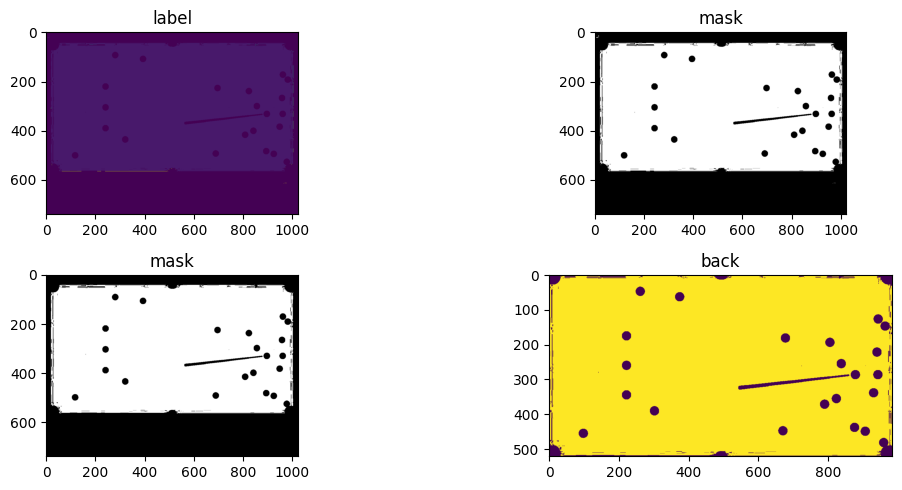

In [156]:
def find_ground1(img, tor=5):
    r, c = np.array(img.shape[:2])//2
    center = img[r-100:r+100, c-100:c+100]
    back = np.argmax(np.bincount(center.ravel()))
    msk = np.abs(img.astype(np.int16) - back)<tor
    lab, n = ndimg.label(msk)
    hist = np.bincount(lab.ravel())
    if hist[1:].max() < 1e4: return None
    if np.argmax(hist[1:])==0: return None
    msk = lab == np.argmax(hist[1:]) + 1
    sr, sc = ndimg.find_objects(msk)[0]
    loc = sr.start, sc.start
    size = sr.stop - loc[0], sc.stop - loc[1]
    return loc, size, sr, sc, msk[sr, sc]

img = imread('window_capture_20250615_173243.png')[:,:,:3]
print(img.shape)
img = rgb2hsv_lut(img)
print(img.shape)
r, c = np.array(img.shape[:2])//2  # r=738//2=369   c=512 
center = img[:,:]  # 80
print(center.ravel())
# plt.imshow(center)
back = np.argmax(np.bincount(center.ravel()))
print(f"back={back}")
msk = np.abs(img.astype(np.int16) - back)<5
lab, n = ndimg.label(msk)

hist = np.bincount(lab.ravel())

msk2 = lab == np.argmax(hist[1:]) + 1  # 提取出最大连通区域
objs = ndimg.find_objects(msk2)  # 经过msk 提取lab ， 又从lab中的最大连通分量重新构造msk，此时的msk2 基本上就是一个连通的目标，提取objects，出来的结果长度应该就是1
# len(objs) 为 1  [(slice(40, 448, None), slice(15, 785, None))]
sr, sc = objs[0]   #  objs[0]是一个边界框，是两个切片对象组成的二元组，分别对应行和列。



# 同时显示原始图像和掩码
plt.figure(figsize=(12, 5))

plt.subplot(221); plt.imshow(lab); plt.title('label')
plt.subplot(222); plt.imshow(msk, cmap='gray'); plt.title('mask')
plt.subplot(223); plt.imshow(msk2, cmap='gray'); plt.title('mask')
plt.subplot(224); plt.imshow(msk2[sr,sc]); plt.title('back')
plt.tight_layout(); plt.show()



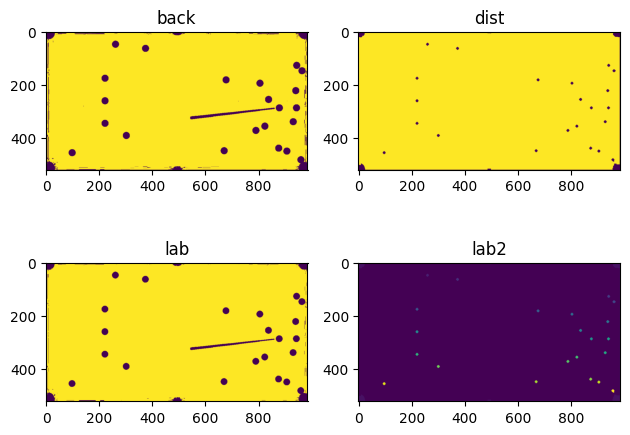

In [158]:
# 找球阶段的输入： msk2[sr,sc]
back = msk[sr,sc]
dist = ndimg.binary_dilation(back, np.ones((13, 13)))
dist2 = ndimg.binary_dilation(back, np.ones((2, 2)))  # 经过背景膨胀，再提取球的连通分量，可以得到球中心坐标，但是不能得到球半径。要想得到球半径，要从未经背景膨胀的图
dist[:,[0,-1]] = 0; dist[[0,-1],:] = 0
lab, n = ndimg.label(~dist)


plt.subplot(221); plt.imshow(back); plt.title('back')
plt.subplot(222); plt.imshow(dist); plt.title('dist')
plt.subplot(223); plt.imshow(dist2); plt.title('lab')
plt.subplot(224); plt.imshow(lab); plt.title('lab2')
plt.tight_layout(); plt.show()

In [159]:
objs = ndimg.find_objects(lab)[1:]
len(objs) # 输出为22，objs就对应着22个球（22个连通区域）

22

In [160]:
lab1, n = ndimg.label(~back)
objs_acr = ndimg.find_objects(lab1)[1:]

ball_info = [[( (obj[0].start + obj[0].stop) // 2, (obj[1].start + obj[1].stop) // 2 ),  # 中心坐标 (row, col)
             (obj[0].stop - obj[0].start, obj[1].stop - obj[1].start)] for obj in objs_acr]  # 边界尺寸 (高度, 宽度)
ball_info = np.array(ball_info)
for i in ball_info:
    if i[1][0] + i[1][1] > 50 and abs(i[1][0] - i[1][1]) < 10:  # 过滤掉尺寸不合适的球
        print(f"center: {i[0]}, size: {i[1]}")  # 输出每个球的中心坐标和尺寸

center: [ 49 261], size: [27 27]
center: [ 65 374], size: [26 27]
center: [128 942], size: [27 27]
center: [149 962], size: [26 27]
center: [177 222], size: [26 26]
center: [183 677], size: [27 26]
center: [195 804], size: [27 27]
center: [223 939], size: [27 26]
center: [256 837], size: [27 26]
center: [261 222], size: [27 26]
center: [288 877], size: [26 27]
center: [288 941], size: [26 27]
center: [340 929], size: [26 27]
center: [346 222], size: [26 26]
center: [356 822], size: [27 27]
center: [372 789], size: [27 27]
center: [391 302], size: [27 26]
center: [439 875], size: [26 26]
center: [448 669], size: [27 27]
center: [450 905], size: [27 27]
center: [456  98], size: [27 27]
center: [503  22], size: [36 45]


In [168]:
def find_ball(img):
    dist = ndimg.binary_dilation(img, np.ones((13, 13)))
    dist[:,[0,-1]] = 0; dist[[0,-1],:] = 0
    lab, n = ndimg.label(~dist)
    objs = ndimg.find_objects(lab)[1:]
    cs = [(i.start+i.stop, j.start+j.stop) for i,j in objs]
    balls = []
    for i in np.array(cs)/2:
        (r, c), ra = find_one(img, i)
        if not ra is None: balls.append([r, c, ra])
    if len(balls)==0: return balls
    balls = np.array(balls)
    balls[:,2] = balls[:,2].mean()-0.5
    return balls

balls = find_ball(back)
balls = np.array(balls)
balls

array([[ 49.04773111, 260.82633212,  13.48011968],
       [ 64.42102936, 373.68294216,  13.48011968],
       [128.20600421, 942.05716691,  13.48011968],
       [148.6145082 , 962.30406822,  13.48011968],
       [176.46203761, 221.46200979,  13.48011968],
       [182.68296866, 676.42103163,  13.48011968],
       [195.04219928, 803.82948043,  13.48011968],
       [222.92821371, 938.559028  ,  13.48011968],
       [255.9662735 , 836.33601032,  13.48011968],
       [260.92589339, 221.42788515,  13.48011968],
       [287.48252173, 876.7064402 ,  13.48011968],
       [287.52053736, 941.15928599,  13.48011968],
       [339.42784515, 928.92589243,  13.48011968],
       [345.46203761, 221.46200979,  13.48011968],
       [356.05716736, 822.20600673,  13.48011968],
       [372.0348375 , 788.85482187,  13.48011968],
       [391.16558197, 301.56900991,  13.48011968],
       [438.67009406, 874.30590157,  13.48011968],
       [448.2452193 , 669.24521748,  13.48011968],
       [449.56897098, 905.16558

In [ ]:
def detect_color(img, balls, mode='snooker'):
    r = int(balls[0,2]) - 1
    rcs = np.mgrid[-r:r+1, -r:r+1].reshape(2,-1).T
    rcs = rcs[norm(rcs, axis=1) < r]
    colors = []
    for r,c in balls[:,:2]:
        rs, cs = (rcs + (int(r), int(c))).T
        colors.append(img[rs, cs])
    colors = np.array(colors).astype(np.int16)
    colors = np.sort(colors, axis=1)
    colors = colors[:,len(rcs)//4:-len(rcs)//4]
    if mode=='snooker':
        snklut = [21, 0, 34, 73, 12, 171, 221, 42]
        cs = [np.argmax(np.bincount(i)) for i in colors]
        diff = np.abs(np.array(cs)[:,None] - snklut)
        return np.argmin(diff, axis=-1)
    
    if mode=='black8':
        bins = np.array([np.bincount(i, minlength=256) for i in colors])
        mean = np.argmax(bins, axis=-1)
        std = (np.std(colors, axis=1)>1) + 1
        std[(std==1) & (np.abs(mean-42)<3)] = 7
        n = (np.abs(colors-28)<3).sum(axis=1)
        n = bins[:,25:30].max(axis=1)
        #print(mean)
        #print(np.bincount(colors[5]))
        #print(np.bincount(colors[9]))
        std[np.argmax(n)] = 0
        return std

hsvbg = img[sr, sc]
r = 13
rcs = np.mgrid[-r:r+1, -r:r+1].reshape(2,-1).T
rcs = rcs[norm(rcs, axis=1) < r]
colors = []
for r,c in balls[:,:2]:
    rs, cs = (rcs + (int(r), int(c))).T
    colors.append(hsvbg[rs, cs])
colors = np.array(colors).astype(np.int16)
colors = np.sort(colors, axis=1)
colors = colors[:,len(rcs)//4:-len(rcs)//4]
cs = [np.argmax(np.bincount(i)) for i in colors]




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [174]:
import matplotlib.pyplot as plt
from skimage.io import imread
from time import time
import numpy as np
from math import sin, cos, pi, asin, acos
pi2, pi = pi * 2, pi

def anglex(dx, dy):
    a = acos(dx / (dx**2 + dy**2)**0.5)
    return a if dy > 0 else pi * 2 - a

class Arc:
    def __init__(self, a1, a2):
        self.a1, self.a2 = a1%pi2, a2%pi2

    def value(self):
        dv = (self.a2 - self.a1) % pi2
        return dv if dv < pi else dv - pi2

    def mid(self):
        v = self.a1 + self.value()/2
        return v % (np.pi*2)

    def contain(self, v):
        da1 = (v - self.a1) % pi2
        da2 = (self.a2 - v) % pi2
        d12 = (self.a2-self.a1)%pi2
        return abs(da1+da2-d12)<1e-5
    
    def minus(self, arc):
        if arc.contain(self.a1):
            self.a1 = arc.a2
        if arc.contain(self.a2):
            self.a2 = arc.a1
        return self.value() > 0

    def __str__(self):
        return 'Arc(%.2f,%.2f)'%(self.a1, self.a2)

class Line:
    def __init__(self, x1, y1, x2, y2):
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2

    def __str__(self):
        return '%s %s'%(self.p1, self)
    def midpoint(self):
        return (self.x1 + self.x2) / 2, (self.y1 + self.y2) / 2


class Path:
    def __init__(self, frm, to, arc, l, layer=0):
        self.frm, self.to, self.arc, self.l = frm, to, arc, l
        self.line, self.point, self.layer = None, None, layer

    def shadow(self, ball):
        dv_x, dv_y = ball.x - self.frm.x, ball.y - self.frm.y
        a = anglex(dv_x, dv_y)
        l = (dv_x**2 + dv_y**2)**0.5
        if l > self.l : return False
        da = asin(min(self.frm.r*2/l, 1))
        arc = Arc(a-da, a+da)
        self.arc.minus(arc)

    def inpoint(self, ball):
        x, y = self.get_point()
        if ((ball.x-x)**2+(ball.y-y)**2)**0.5<ball.r*2:
            self.arc.a1, self.arc.a2 = 0.1, -0.1

    def get_line(self):
        if not self.line is None: return self.line
        x, y, arc, r = self.frm.x, self.frm.y, self.arc, self.frm.r*2
        x1, y1 = cos(arc.a1+pi) * r + x, sin(arc.a1+pi) * r + y
        x2, y2 = cos(arc.a2+pi) * r + x, sin(arc.a2+pi) * r + y
        self.line = Line(x2, y2, x1, y1)                       # x1, y1 和 x2, y2 是两条边界射线的终点
        return self.line

    def get_point(self):
        if not self.point is None: return self.point
        x, y, arc, r = self.frm.x, self.frm.y, self.arc, self.frm.r
        x, y = cos(arc.mid()) * self.l + x, sin(arc.mid()) * self.l + y
        self.point = (x, y)
        return self.point   # 返回终点坐标
        

class Ball:
    def __init__(self, x, y, r, tp):
        self.x, self.y, self.r, self.tp = x, y, r, tp

    def distance(self, ball):
        return ((ball.x - self.x)**2 + (ball.y - self.y)**2)**0.5

    def to_line(self, line, buf=False):
        # 返回： 一个Path对象，球到一个线段的路径
        isline = isinstance(line, Line)
        ln = line if isline else line.get_line()        # 这里传进来的line，有可能是line对象，也可能是Path对象
        dv1_x, dv1_y = ln.x1 - self.x, ln.y1 - self.y   # 球心到线段点1的向量
        dv2_x, dv2_y = ln.x2 - self.x, ln.y2 - self.y   # 球心到线段点2的向量
        a1 = anglex(dv1_x, dv1_y)                      
        a2 = anglex(dv2_x, dv2_y)                       # 根据向量，可以求出两个角度
        l1 = (dv1_x**2 + dv1_y**2)**0.5                 # 球心到线段点1的距离
        l2 = (dv2_x**2 + dv2_y**2)**0.5                 # 球心到线段点2的距离
        if isline:
            # 如果目标是线段（如袋口），调整角度考虑球的半径
            a1 += asin(min(self.r / l1, 1))
            a2 -= asin(min(self.r / l2, 1))
        arc = Arc(a1, a2)
        layer = 0 if isline else line.layer + 1          
        return Path(self, line, arc, (l1+l2)/2, layer)    # 长度用到两个端点的长度的平均来作为长度

class Table:
    def __init__(self, loc, size, back, balls, tp='black8'):
        self.loc, self.size = loc, size
        self.back, self.balls = back, balls
        self.balls = [Ball(y,x,r,int(tp)) for y, x, r, tp in balls]
        self.unit = self.size[1]/100
        self.paths = self.hitpts = []
        
        if tp=='black8': self.make_pocket(1.5, 2.7)
        if tp=='snooker': self.make_pocket(1, 3)

    def make_pocket(self, k1, k2):
        unit, h, w = self.unit, *self.size
        mar = self.mar = unit * k1
        lst = []
        lst.append(Line(mar, mar+mar*k2, mar+mar*k2, mar))
        lst.append(Line(mar, w/2+mar*k2, mar, w/2-mar*k2))
        lst.append(Line(mar+mar*k2, w-mar, mar, w-mar-mar*k2))
        lst.append(Line(h-mar, w-mar-mar*k2, h-mar-mar*k2, w-mar))
        lst.append(Line(h-mar, w/2-mar*k2, h-mar, w/2+mar*k2))
        lst.append(Line(h-mar-mar*k2, mar, h-mar, mar+mar*k2))
        self.pocket = lst

    def show(self):
        import numpy as np
        plt.imshow(self.back)
        angs = np.linspace(0, np.pi*2, 36)
        rs, cs = np.cos(angs), np.sin(angs)
        lut = np.array([(255,255,255), (255,0,0),
            (255,255,0), (0,255,0), (128,0,0),
            (0,0,255), (255,128,128), (50,50,50)])/255
        for i in self.balls:
            plt.plot(cs*i.r+i.y, rs*i.r+i.x, c=lut[i.tp])
        h, w, mar = *self.size, self.mar
        print(h, w, mar)
        plt.plot([mar, mar, w-mar, w-mar, mar],
                 [mar, h-mar, h-mar, mar, mar], 'blue')
        for line in self.pocket:
            r1, c1, r2, c2 = line.x1, line.y1, line.x2, line.y2
            plt.plot([c1,c2], [r1,r2], 'white')
        for p in self.paths: self.plot_path(p)     # path是进球的线
        if len(self.hitpts)>0:
            plt.plot(self.hitpts[:,1], self.hitpts[:,0], 'r.')  # hitpts是一个点
        plt.show()

    def plot_path(self, path):
        x, y, arc, l = path.frm.x, path.frm.y, path.arc, path.l
        p = path.get_point()
        #p3 = cos(arc.a2)*l+x, sin(arc.a2)*l+y
        plt.plot([p[1], y], [p[0], x], 'yellow')

    def solve(self, goal=-1, maxiter=1):
        self.paths = self.pocket.copy()
        for i in range(1000):
            if i == len(self.paths): break
            cur = self.paths[i]
            if i>5 and cur.layer == maxiter: break
            if isinstance(cur, Line): # 入袋球
                if goal!=-1: balls = [i for i in self.balls if i.tp==goal]
                else: balls = [i for i in self.balls if i.tp!=0]
            elif cur.layer == maxiter-2 and goal!=-1:
                balls = [i for i in self.balls if i.tp in (goal,0)]
            elif cur.layer == maxiter-1: # 回归母球
                balls = [i for i in self.balls if i.tp==0]
            else: balls = self.balls

            for ball in balls:
                if ball.tp==0 and goal!=-1 and cur.frm.tp!=goal: continue
                path = ball.to_line(cur)
                for b in self.balls:
                    if b != ball: path.shadow(b)
                for b in self.balls:
                    if b != ball and i>5 and b != path.to.frm:
                        path.inpoint(b)
                if path.arc.value()>0.0005:
                    self.paths.append(path)
        self.paths = self.paths[6:]

        for cur in self.paths[::-1]:
            if cur.frm.tp==0 and cur.layer>0:
                while cur.layer>0:
                    cur.layer *= -1
                    cur = cur.to
                    if cur.layer==0:
                        cur.layer=-10
        self.paths = [i for i in self.paths if i.layer<0]
        pts = [i for i in self.paths if i.frm.tp==0]
        rst = []
        for i in pts:
            x = cos(i.arc.mid()) * i.l + i.frm.x
            y = sin(i.arc.mid()) * i.l + i.frm.y
            # x, y, type, time, angle
            rst.append([x, y, i.to.frm.tp, abs(i.layer), min(i.to.arc.value()*1000, 100)])
        self.hitpts = np.array(rst)


In [164]:
balls = np.array(balls)
cs = np.array(cs)
balls_cs = np.hstack((balls, cs[:,None]))
balls_cs

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 21 and the array at index 1 has size 22

221 粉球
0 红球
73 绿球 
42 黑球
12 咖啡求
21 白球
34 黄球 
171 蓝球

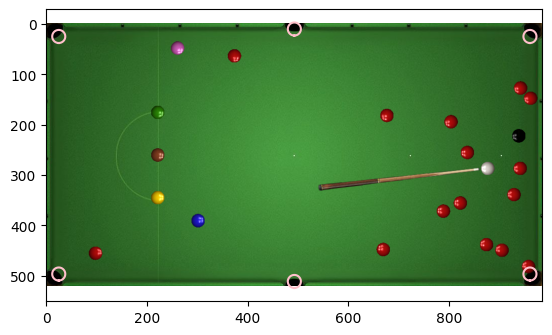

In [178]:
img12 = imread('window_capture_20250615_173243.png')[:,:,:3]
table = extract_table(img12, mode='snooker')
table = Table(* table, 'snooker')
# table.show()

# import numpy as np
# plt.imshow(self.back)
angs = np.linspace(0, np.pi*2, 36)
rs, cs = np.cos(angs), np.sin(angs)
# lut = np.array([(255,255,255), (255,0,0),
#     (255,255,0), (0,255,0), (128,0,0),
#     (0,0,255), (255,128,128), (50,50,50)])/255
# for i in self.balls:
#     plt.plot(cs*i.r+i.y, rs*i.r+i.x, c=lut[i.tp])
# h, w, mar = *self.size, self.mar
# print(h, w, mar)
# plt.plot([mar, mar, w-mar, w-mar, mar],
#             [mar, h-mar, h-mar, mar, mar], 'blue')
# for line in self.pocket:
#     r1, c1, r2, c2 = line.x1, line.y1, line.x2, line.y2
#     plt.plot([c1,c2], [r1,r2], 'white')
# for p in self.paths: self.plot_path(p)     # path是进球的线
# if len(self.hitpts)>0:
#     plt.plot(self.hitpts[:,1], self.hitpts[:,0], 'r.')  # hitpts是一个点
# plt.show()

plt.imshow(table.back)
for line in table.pocket:
    pocketpoint = line.midpoint()
    # plt.plot(pocketpoint[1], pocketpoint[0], 'ro')  # 绘制袋口位置
    plt.plot(cs*13+pocketpoint[1], rs*13+pocketpoint[0], c='pink')
plt.show()